# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

img_size = 64

#https://airobott.blogspot.com/2020/05/how-to-generate-faces-using-vae-with.html

## Load dataset

In [2]:
from __future__ import print_function
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import random


save_dir = os.path.join(os.getcwd(), 'saved_models')
emb_model_name = 'mxnet1k_emb_model.h5'


data_dir = 'datasets/'
ds_name = 'mxnet1k'
ds_arc_file = 'mxnet1k.zip'

def parse_cls_name_mxnet(fn):
    s = fn
    return s

def load_data_mxnet_dataset(data_path, max_per_person = 10):
    classes = []
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    print(data_path)

    dirnames = [fn for fn in os.listdir(data_path)]
    for dir in dirnames:
        x_cls_data = []
        y_cls_data = []
        # print(dir)

        cls_path = os.path.join(data_path, dir)
        fnames = [fn for fn in os.listdir(cls_path) if fn.endswith((".png",".jpg",".bmp"))]

        max_cnt = min(max_per_person, len(fnames))
        i = 0
        for fn in fnames:
            img = cv2.imread(os.path.join(cls_path, fn))
            img = cv2.resize(img,(img_size, img_size))
            cls_name = parse_cls_name_mxnet(dir)
            try:
                cls_ind = classes.index(cls_name)
            except:
                classes.append(cls_name)
                cls_ind = classes.index(cls_name)
            x_cls_data.append(img)
            y_cls_data.append(cls_ind)
            i += 1
            if i >= max_cnt:
                break

        x_train.extend(x_cls_data)
        y_train.extend(y_cls_data)

    x_data_np = np.asarray(x_train)
    #x_data_np = np.expand_dims(x_data_np, axis=3)
    y_data_np = np.asarray(y_train)
    return x_data_np, y_data_np, classes


classes = []
x_train, y_train, classes = load_data_mxnet_dataset(os.path.join(data_dir, ds_name), 30)

num_classes = len(classes)

#plt.hist(y_test, num_classes)
#plt.show()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(num_classes,'classes')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = x_train.astype('float32')

x_train /= 255

datasets/mxnet1k
x_train shape: (27655, 64, 64, 3)
27655 train samples
1000 classes
y_train shape: (27655,)


## Create a sampling layer

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Define the VAE as a `Model` with a custom `train_step`

In [6]:
import tensorflow.keras.backend as K

class VAE():
    def __init__(self, encoder, decoder, z_mean, z_log_var):
        self.encoder = encoder
        self.decoder = decoder
        self.log_var = z_log_var
        self.mu = z_mean

        model_input = self.encoder.inputs
        model_output = self.decoder(self.encoder.outputs)


        self.model = Model(model_input, model_output)

    def compile(self):
        def vae_r_loss(y_true, y_pred):
            #print(y_true[0].shape, y_pred.shape)
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])#tf.reduce_mean(tf.square(y_true[0] - y_pred[0]))

            return 10000 * r_loss

        def vae_kl_loss(y_true, y_pred):
            print(self.log_var.shape, self.mu[0].shape)
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = [1])

            return 1*kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = keras.optimizers.legacy.Adam(lr=0.001)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])


## Вариант улучшения 1 - успех, удалось достигнуть некоторых визуальных улучшений

#### Build the encoder (со внесенными изменениями)

In [55]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(img_size, img_size, 3))

x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim)(x)
x = layers.LeakyReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_70 (Conv2D)             (None, 64, 64, 32)   896         ['input_33[0][0]']               
                                                                                                  
 leaky_re_lu_172 (LeakyReLU)    (None, 64, 64, 32)   0           ['conv2d_70[0][0]']              
                                                                                                  
 batch_normalization_156 (Batch  (None, 64, 64, 32)  128         ['leaky_re_lu_172[0][0]']        
 Normalization)                                                                             

#### Build the decoder (со внесенными изменениями)

In [56]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(8 * 8 * 64)(latent_inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Reshape((8, 8, 64))(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_33 (Dense)            (None, 4096)              45056     
                                                                 
 leaky_re_lu_178 (LeakyReLU)  (None, 4096)             0         
                                                                 
 batch_normalization_161 (Ba  (None, 4096)             16384     
 tchNormalization)                                               
                                                                 
 reshape_16 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_86 (Conv2D  (None, 16, 16, 128)      73856     
 Transpose)                                                

#### Обучим модель

In [57]:
vae = VAE(encoder, decoder, z_mean, z_log_var)
vae.compile()

vae.model.fit(x_train, x_train,
          batch_size=128,
          epochs=30,
          #callbacks=[checkpoint_callback],
          shuffle=True)


(None, 10) (10,)
(None, 10) (10,)
Train on 27655 samples
Epoch 1/30
27655/27655 [==============================] - 37s 1ms/sample - loss: 547.5909 - vae_r_loss: 456.7286 - vae_kl_loss: 90.8622
Epoch 2/30
27655/27655 [==============================] - 33s 1ms/sample - loss: 299.1306 - vae_r_loss: 275.7685 - vae_kl_loss: 23.3620
Epoch 3/30
27655/27655 [==============================] - 33s 1ms/sample - loss: 263.6140 - vae_r_loss: 241.9138 - vae_kl_loss: 21.7002
Epoch 4/30
27655/27655 [==============================] - 33s 1ms/sample - loss: 244.0437 - vae_r_loss: 222.7990 - vae_kl_loss: 21.2446
Epoch 5/30
27655/27655 [==============================] - 33s 1ms/sample - loss: 232.5736 - vae_r_loss: 211.5069 - vae_kl_loss: 21.0668
Epoch 6/30
27655/27655 [==============================] - 33s 1ms/sample - loss: 222.9937 - vae_r_loss: 201.2533 - vae_kl_loss: 21.7404
Epoch 7/30
27655/27655 [==============================] - 33s 1ms/sample - loss: 218.7794 - vae_r_loss: 197.1876 - vae_kl_loss:

#### Результат Варианта 1

Проверяем автоэнкодер в целом

(27655, 64, 64, 3)
(1, 64, 64, 3)
[[-2.414882   -0.36816263 -1.8830496  -0.7404462   1.3497674  -2.2578044
   0.76573956 -1.2131135  -0.07903057  0.07375863]]


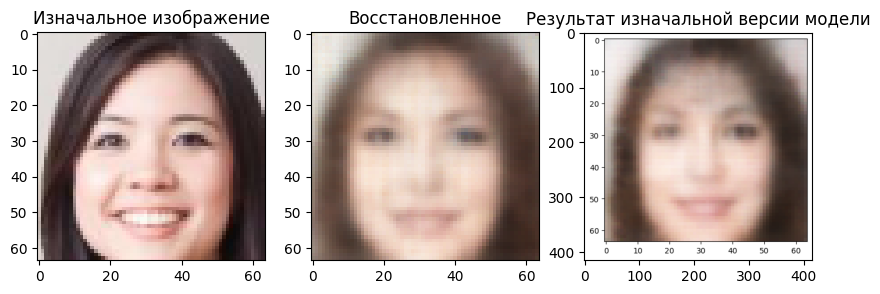

In [60]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

images = []
np_images = []
i = 200

images.append(np.expand_dims(x_train[i], axis=0))
np_images = np.vstack(images)
print(x_train.shape)
print(np_images.shape)
emb = vae.encoder.predict(np_images)
print(emb)
x_decoded = vae.decoder.predict(emb)
digit = x_decoded[0].reshape(img_size, img_size, 3)

# Чтение третьего изображения из файла
third_image = cv2.imread('var0op.png')
third_image = cv2.cvtColor(third_image, cv2.COLOR_BGR2RGB)

# Показ первого изображения
plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.title("Изначальное изображение")

# Показ второго изображения
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.title("Восстановленное")

# Показ третьего изображения
plt.subplot(1, 3, 3)
plt.imshow(third_image, cmap="Greys_r")
plt.title("Результат изначальной версии модели")

plt.show()


**Внесенные изменений привели к чуть больее отчетливым чертам лица на восстановленном изоблажении (лучше видны линии рта) по сравнению с изображением, восставновленным изначальной версией модели (я прогнал ее и сохранил результат).**

## Display a grid of sampled digits Варианта 1

x_train shape: (27655, 64, 64, 3)


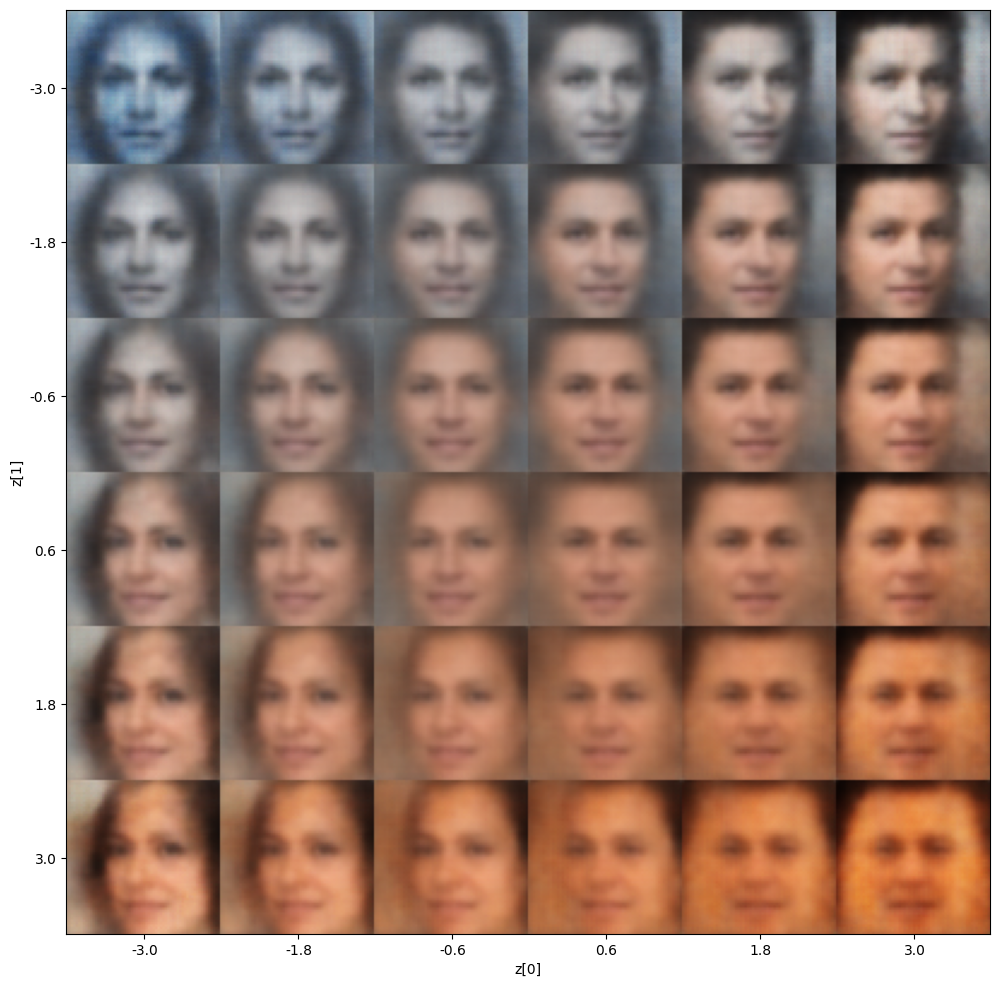

In [61]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=6, figsize=12):
    # display a n*n 2D manifold of digits

    scale = 3.0
    figure = np.zeros((img_size * n, img_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)#[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1,latent_dim))
            #z_sample[0,:] = 1
            z_sample[0,0] = xi
            z_sample[0,3] = yi
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            digit = cv2.cvtColor(digit, cv2.COLOR_BGR2RGB)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

print('x_train shape:', x_train.shape)
plot_latent_space(vae)

## Вариант улучшения 2 - неудача

#### Build the encoder (со внесенными изменениями)

In [65]:
latent_dim_2 = 20

encoder_inputs = keras.Input(shape=(img_size, img_size, 3))

x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim_2)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim_2, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim_2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder2 = keras.Model(encoder_inputs, z, name="encoder2")
encoder2.summary()

Model: "encoder2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_80 (Conv2D)             (None, 64, 64, 32)   896         ['input_37[0][0]']               
                                                                                                  
 re_lu_12 (ReLU)                (None, 64, 64, 32)   0           ['conv2d_80[0][0]']              
                                                                                                  
 dropout_11 (Dropout)           (None, 64, 64, 32)   0           ['re_lu_12[0][0]']               
                                                                                           

#### Build the decoder (со внесенными изменениями)

In [66]:
latent_inputs_2 = keras.Input(shape=(latent_dim_2,))

x = layers.Dense(8 * 8 * 64)(latent_inputs_2)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Reshape((8, 8, 64))(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder2 = keras.Model(latent_inputs_2, decoder_outputs, name="decoder2")
decoder2.summary()

Model: "decoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 20)]              0         
                                                                 
 dense_37 (Dense)            (None, 4096)              86016     
                                                                 
 re_lu_18 (ReLU)             (None, 4096)              0         
                                                                 
 dropout_16 (Dropout)        (None, 4096)              0         
                                                                 
 reshape_18 (Reshape)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_98 (Conv2D  (None, 16, 16, 128)      73856     
 Transpose)                                                      
                                                          

#### Обучим модель

In [67]:
vae2 = VAE(encoder2, decoder2, z_mean, z_log_var)
vae2.compile()

vae2.model.fit(x_train, x_train,
          batch_size=186,
          epochs=30,
          #callbacks=[checkpoint_callback],
          shuffle=True)


c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(None, 20) (20,)
(None, 20) (20,)
Train on 27655 samples
Epoch 1/30
27655/27655 [==============================] - 53s 2ms/sample - loss: 641.2287 - vae_r_loss: 641.2260 - vae_kl_loss: 0.0029
Epoch 2/30
27655/27655 [==============================] - 46s 2ms/sample - loss: 599.4065 - vae_r_loss: 599.4011 - vae_kl_loss: 0.0056
Epoch 3/30
27655/27655 [==============================] - 47s 2ms/sample - loss: 592.9793 - vae_r_loss: 592.9688 - vae_kl_loss: 0.0105
Epoch 4/30
27655/27655 [==============================] - 47s 2ms/sample - loss: 590.5141 - vae_r_loss: 590.4990 - vae_kl_loss: 0.0152
Epoch 5/30
27655/27655 [==============================] - 46s 2ms/sample - loss: 589.1392 - vae_r_loss: 589.1194 - vae_kl_loss: 0.0199
Epoch 6/30
27655/27655 [==============================] - 47s 2ms/sample - loss: 588.4985 - vae_r_loss: 588.4756 - vae_kl_loss: 0.0229
Epoch 7/30
27655/27655 [==============================] - 47s 2ms/sample - loss: 587.5728 - vae_r_loss: 587.5483 - vae_kl_loss: 0.024

(27655, 64, 64, 3)
(1, 64, 64, 3)


c:\Users\Kreal\miniconda3\envs\ts\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[ 0.0824957   0.45535275 -0.3652724   0.6199488   0.3302582  -1.2639049
  -0.15264475  0.3183626   0.30282995 -0.56400585 -0.4011438   0.60225874
   0.30377892  0.25969025  1.031767   -1.031921    0.06091592  0.61007077
   1.1193887   2.0673313 ]]


Text(0.5, 1.0, 'Результат изначальной версии модели')

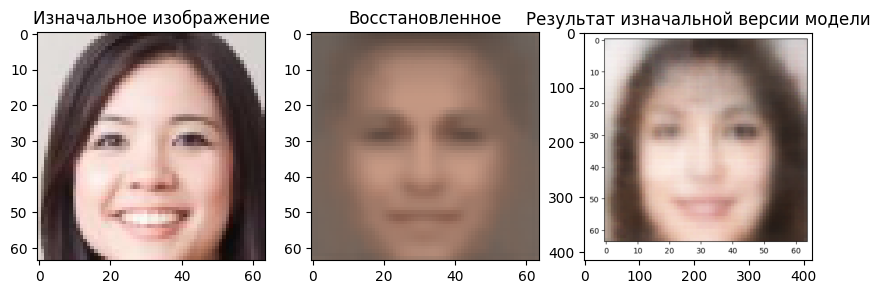

In [68]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

images = []
np_images = []
i = 200

images.append(np.expand_dims(x_train[i], axis=0))
np_images = np.vstack(images)
print(x_train.shape)
print(np_images.shape)
emb = vae2.encoder.predict(np_images)
print(emb)
x_decoded = vae2.decoder.predict(emb)
digit = x_decoded[0].reshape(img_size, img_size, 3)

# Чтение третьего изображения из файла
third_image = cv2.imread('var0op.png')
third_image = cv2.cvtColor(third_image, cv2.COLOR_BGR2RGB)

# Показ первого изображения
plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.title("Изначальное изображение")

# Показ второго изображения
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.title("Восстановленное")

# Показ третьего изображения
plt.subplot(1, 3, 3)
plt.imshow(third_image, cmap="Greys_r")
plt.title("Результат изначальной версии модели")

Как можно заметить, использование ReLU и Dropout **заместо ухудшило** качество восстановления. Поэтому далее в коде работа будет идти с улучшенной моделью из варианта 1.

## Векторная арифметика

(3, 64, 64, 3)
[[-0.6996849  -0.17709246  0.18481109  0.08346369 -1.3696743  -0.81423616
   0.82608485 -0.28370285 -0.06286381 -1.0758752 ]
 [-0.39210966  1.140271    0.08119267  1.0654613   0.5476031  -1.18103
  -0.07401127  0.62864774 -0.3436104  -1.3152909 ]
 [-0.446481    0.15069945 -1.0929738   0.21364123  1.6483942  -0.4894116
  -0.37908164 -0.17762697  0.51284355 -0.2372366 ]]
smile [-0.30757526 -1.3173634   0.10361841 -0.9819976  -1.9172773   0.36679387
  0.9000961  -0.9123506   0.28074658  0.23941576]
(64, 64, 3)


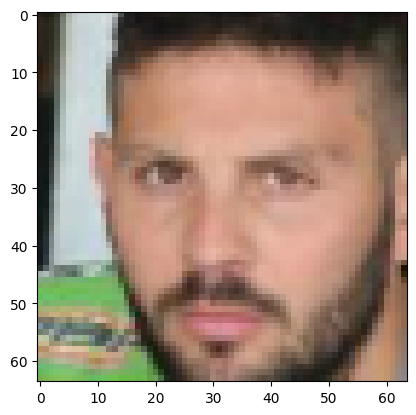

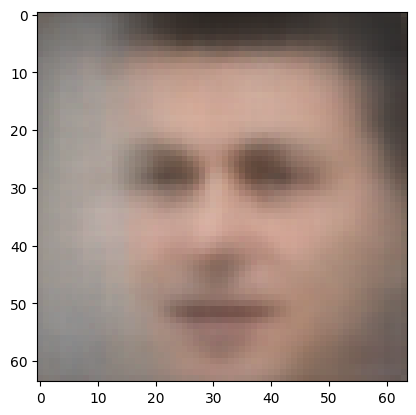

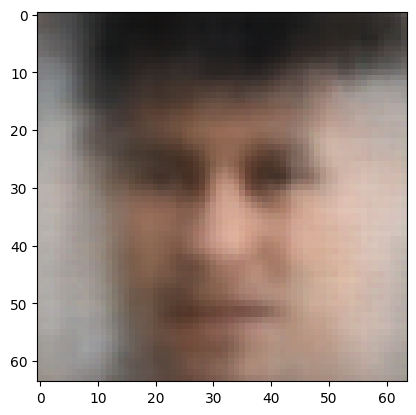

In [14]:
img1 = cv2.imread('datasets/mxnet1k/mxnet_47/3644.png') #reference with smile
img1 = cv2.resize(img1,(img_size, img_size))
img2 = cv2.imread('datasets/mxnet1k/mxnet_47/3646.png') #reference without smile
img2 = cv2.resize(img2,(img_size, img_size))
img3 = cv2.imread('datasets/mxnet1k/mxnet_45/3494.png') #new without smile
img3 = cv2.resize(img3,(img_size, img_size))

images = []
images.append(np.expand_dims(img1, axis=0))
images.append(np.expand_dims(img2, axis=0))
images.append(np.expand_dims(img3, axis=0))
np_images = np.vstack(images)
#np_images = np.expand_dims(np_images, axis=3)

np_images = np_images.astype('float32')
np_images /= 255
print(np_images.shape)

emb = vae.encoder.predict(np_images)

print(emb)
smile = emb[0]-emb[1]

print("smile", smile)

smiled_man = emb[2].copy()#+smile
smiled_man[3] -= 3

x_decoded = vae.decoder.predict(np.expand_dims(emb[2], axis=0))
digit_src = x_decoded[0].reshape(img_size, img_size, 3)

x_decoded = vae.decoder.predict(np.expand_dims(smiled_man, axis=0))
digit = x_decoded[0].reshape(img_size, img_size, 3)

img3 = img3/255
print(img3.shape)
img = np.zeros((64,64,3),float)
img[:,:,0] = img3[:,:,2]
img[:,:,1] = img3[:,:,1]
img[:,:,2] = img3[:,:,0]
plt.imshow(img, cmap="Greys_r")
plt.show()
plt.imshow(cv2.cvtColor(digit_src, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.show()
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.show()


Гистограммы компонентов вектора улыбки

In [15]:
img1 = cv2.imread('datasets/mxnet1k/mxnet_47/3644.png') #reference with smile
img1 = cv2.resize(img1,(img_size, img_size))
img2 = cv2.imread('datasets/mxnet1k/mxnet_47/3646.png') #reference without smile
img2 = cv2.resize(img2,(img_size, img_size))
img3 = cv2.imread('datasets/mxnet1k/mxnet_45/3494.png') #new without smile
img3 = cv2.resize(img3,(img_size, img_size))

images = []
images.append(np.expand_dims(img1, axis=0))
images.append(np.expand_dims(img2, axis=0))
images.append(np.expand_dims(img3, axis=0))
np_images = np.vstack(images)
#np_images = np.expand_dims(np_images, axis=3)

np_images = np_images.astype('float32')
np_images /= 255
print(np_images.shape)

smile_stat = np.zeros((100,latent_dim), float)
for i in range(100):
    emb = vae.encoder.predict(np_images)

    #print(emb)
    smile = emb[0]-emb[1]
    smile_stat[i] = smile
    #print("smile", smile)
plt.hist(smile_stat[:,19], 20, (-5,5))
plt.show()


(3, 64, 64, 3)


IndexError: index 19 is out of bounds for axis 1 with size 10